# Importations

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from hmmlearn import hmm
# from hmm_functions import *
# from runs_functions import *
# from plots_functions import *
# from analysis_functions import *

# Import Data

In [10]:
path_to_data_folder='/LocalData/ForagingMice/4TowersTaskMethodPaper_Data/Group2Data'

# Analysing the entire group of mice

mice_sample_group_2 = ['MOU3974','MOU3975', 'MOU3987', 'MOU3988', 'MOU3991', 'MOU3992', 'MOU4551', 'MOU4552', 'MOU4560', 'MOU4561', 'MOU4562',
               'MOU4563', 'MOU4623', 'MOU4964', 'MOU4965', 'MOU4986', 'MOU4987', 'MOU4988', 'MOU4993', 'MOU5007', 'MOU5008']

# List of mice that were not used to train the HMM
test_mice = ['MOU4993',
             'MOU3974',
             'MOU3992',
             'MOU4987',
             'MOU4988'
            ]

### Test mice ###

## CW
# MOU4993

## CCW
# MOU3974
# MOU3992
# MOU4987 
# MOU4988

### Loading HMM ###
model = f'best_model_score_19_type2_v1'

with open(f'/home/david/Documents/code/phd/Maud_analysis/HMM/{model}.pkl', 'rb') as file:
    model = pickle.load(file)

# Functions

### Data handling

In [11]:
def load_pickle_data(folder_path_mouse_to_analyse,session_index):

    """
    Load pickle data file

    Arguments:
        folder_path_mouse_to_analyse (str): path to mouse folder
        session_index (int): index of the session from which to load the pickle data file
    
    Returns:
        (list) data from pickle file 

    """

    # Get all session folders that start with 'MOU' and sort them
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    session_to_analyse = sessions_to_analyse[session_index]

    # Define the output pickle filename and its full path
    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)

    # Open and load the session data from the pickle file
    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    return session_data

### To set data in the right format

In [12]:
def order_runs(all_epochs):

    """
    Sort epochs in chronological order, omitting immobility epochs.

    Arguments:
        all_epoch (dict): dictionnary containing all the epochs, sorted by type of epoch. Each key is a different type of epoch.

    Returns:
        list: ordered_all_runs containing all the epochs omitting immobility epochs, sorted in chronological way.
        list: ordered_all_runs_frames containing all the epoch's frame intervals, omitting immobility epochs, sorted in chronological way.

    """

    # Initialize empty lists to store ordered runs and their first frames
    ordered_all_runs = []
    ordered_all_runs_frames = []

    # Loop through each key in the all_epochs dictionary
    for k in all_epochs.keys():
        
        # Loop through each run in the current key's list
        for i in range(len(all_epochs[k])):
            
            # Treats immobility differently because of a structure difference of the epoch variables
            if k != 'immobility':
        
                # Add the current run to ordered_all_runs
                ordered_all_runs.append([k] + all_epochs[k][i])
                # Add the first frame of the current run to ordered_all_runs_frames
                ordered_all_runs_frames.append(all_epochs[k][i][0])

            else: 
            
                continue

    # Sort the frames list based on the first element of each frame
    ordered_all_runs_frames = sorted(ordered_all_runs_frames, key=lambda x: x[1])
    # Sort the runs list based on the first element of each run
    ordered_all_runs = sorted(ordered_all_runs, key=lambda x: x[1])

    # Return the ordered lists of runs and their first frames
    return ordered_all_runs, ordered_all_runs_frames

In [13]:
def identify_run(epoch):

    """
    Returns the index of run type. 0 is run_around_tower_CW, 1 is run_around_tower_CCW etc.

    Arguments:
        epoch (list): list containing epoch

    Returns:
        run (list): Containi
        run_types (list): list containing run types label

    """

    # Run types label
    run_types = ['run_around_tower_CW', 'run_around_tower_CCW', 'run_between_towers', 'run_toward_tower', 'exploratory_run']

    # Checks if the epoch is a run around tower. If it is, separate CW and CCW
    if epoch[0]!='run_around_tower':

        run_name = epoch[0]

    else:

        direction = epoch[4]['direction']
        run_name = f'{epoch[0]}_{direction}'

    # Find the index of the run label in run_types
    run = run_types.index(run_name)

    return run, run_types

In [14]:
def extract_runs_sequence(path_to_data_folder, mouse, session_index):

    """
    Extract the sequence of runs and convert it into a sequence of numbers so that it can be handled by the HMM

    Arguments:
        path_to_data_folder (string): path to the folder where the data folder of each mous is stored
        mouse (string): name of the mouse
        session_index (int): index of the session from which to extract runs

    Return:
        ordered_runs_types_number (numpy.ndarray): sequence of runs with their type identified by a number
        ordered_runs_frames (numpy.ndarray): sequence of frames intervals of each run
        run_types (list): list containing run types label
    
    """

    # Define the path to mouse's data
    mouse_folder_path = os.path.join(path_to_data_folder, mouse)

    # Extract epochs
    data = load_pickle_data(mouse_folder_path, session_index)

    # Order the runs (i.e order the epochs ommiting the immobilities)
    ordered_epochs, ordered_epochs_frames = order_runs(data['all_epochs'])

    ordered_runs_types_number = []
    ordered_runs_frames = []

    # For each run, converts its run type into a number and find its frames interval
    for i in range(len(ordered_epochs)):

        run, run_types = identify_run(ordered_epochs[i])

        ordered_runs_types_number.append(run)
        ordered_runs_frames.append(ordered_epochs_frames[i])
    
    # Convert into numpy.ndarray
    ordered_runs_types_number = np.array(ordered_runs_types_number) 
    ordered_runs_frames = np.array(ordered_runs_frames)

    return ordered_runs_types_number, ordered_runs_frames, run_types

# Analysis

### Extract mouse's data

In [15]:
# Choose the index of the mouse to be analysed
mouse_index = 2
mouse_name = test_mice[mouse_index]

# Choose the index of the session to be analysed
session_index = 16

folder_path_mouse_to_analyse = os.path.join(path_to_data_folder,mouse_name)

# Extract the sequence of runs 
mouse_runs_sequence, _, run_types = extract_runs_sequence(path_to_data_folder, mouse_name, session_index)
mouse_num_runs = len(mouse_runs_sequence)

# Precdict the states sequence corresponding mouse_runs_sequence with the loaded HMM
states_sequence = model.predict(np.int16(mouse_runs_sequence.reshape(-1,1)))



### Plot

['run_around_tower_CW', 'run_around_tower_CCW', 'run_between_towers', 'run_toward_tower', 'exploratory_run']


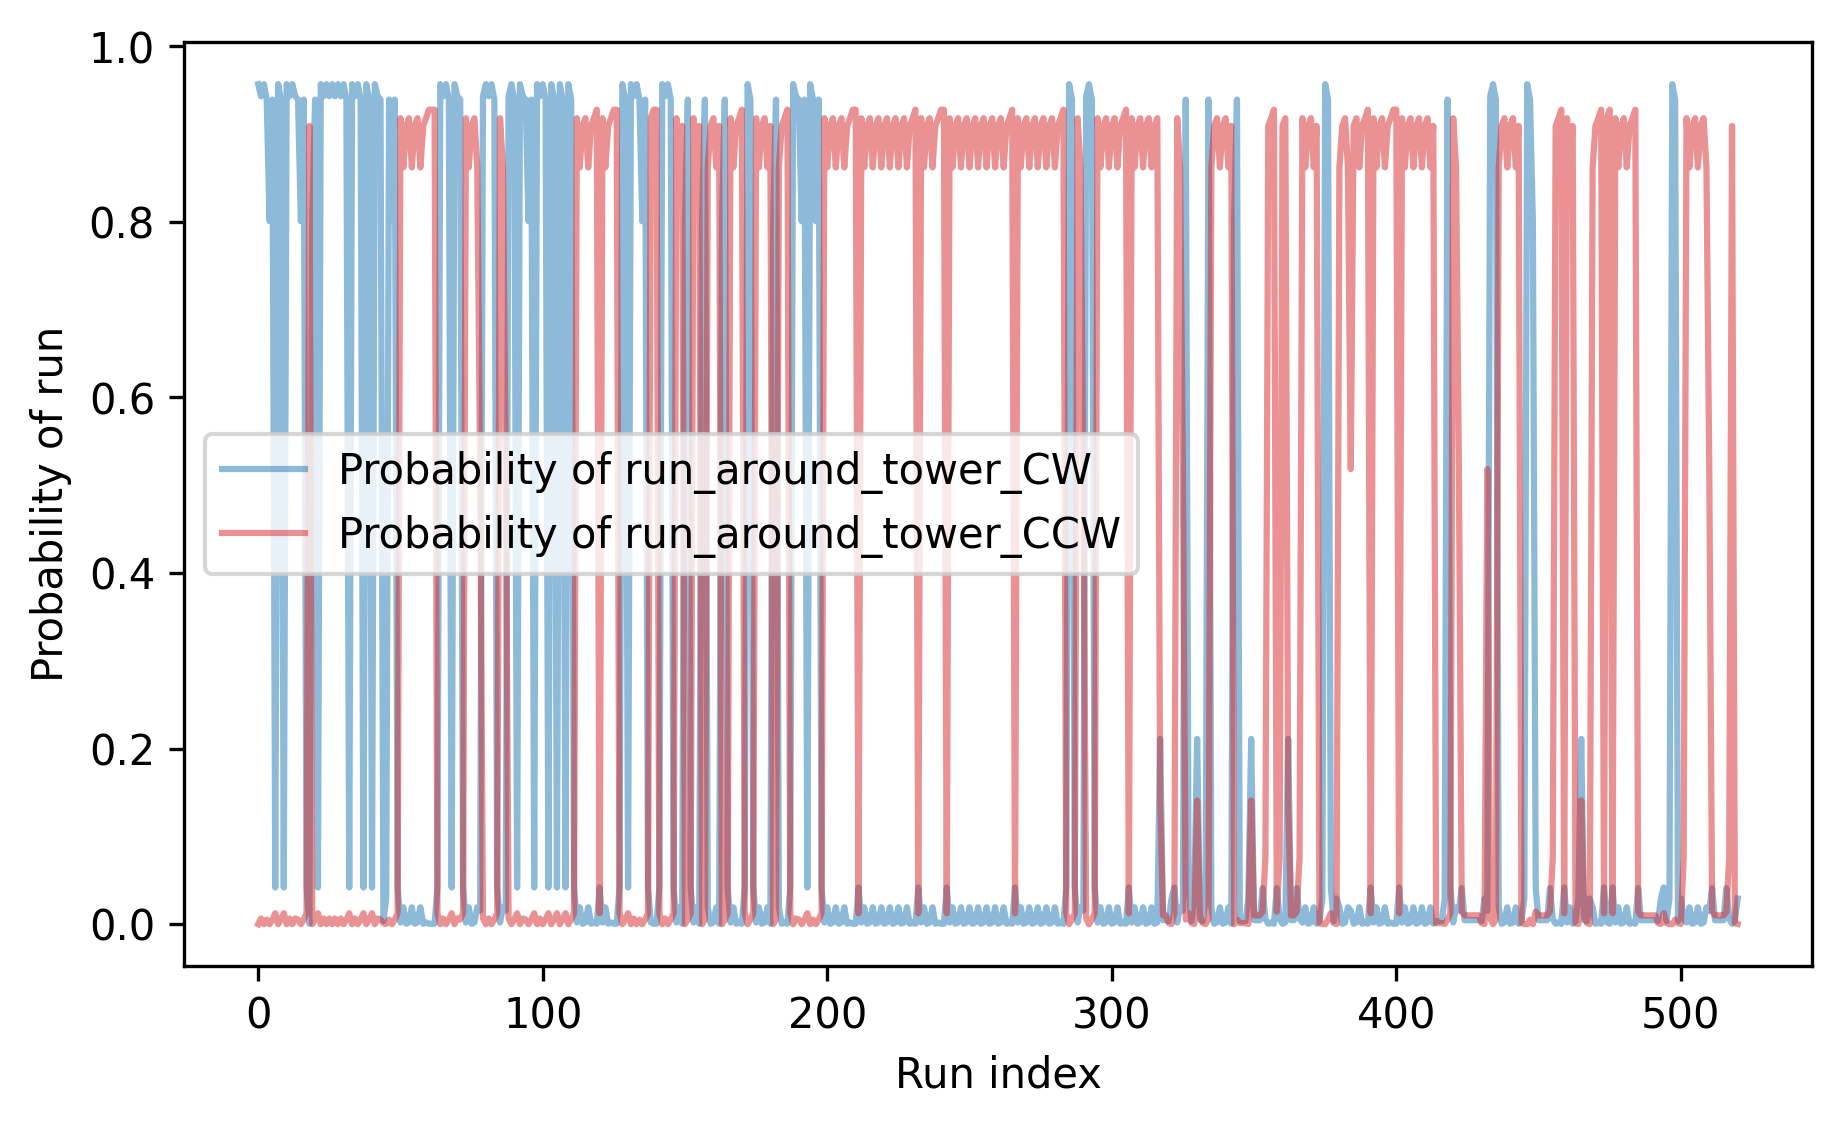

In [ ]:
fig=plt.figure(figsize=(7, 4), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(1, 1)
row = gs[0,0].subgridspec(1, 1)
ax = plt.subplot(row[0,0])

colors_for_run = ['#1f77b4', '#d62728','#2ca02c','#bcbd22','#ff7f0e']

# Define the emission probability matrix i.e the matrix associating the probability to execute each run for each state
emissionprob = model.emissionprob_

# For each run type, plot the sequence of probability to exectute a run of the given type at each step according to the HMM
for i, run_type in enumerate(run_types):

    reconstructed_proba_seq = []
    
    # Only diplay CW and CCW QTs
    if i >= 2:

        break

    for s in states_sequence:

        reconstructed_proba_seq.append(emissionprob[s][i])

    ax.plot(np.arange(mouse_num_runs), reconstructed_proba_seq, label=f'Probability of {run_type}', color=colors_for_run[i], alpha=0.5, zorder=0)

ax.set_xlabel('Run index')
ax.set_ylabel('Probability of run')

ax.legend()

print(run_types)